In [30]:
import pandas as pd
import numpy as np
import xgboost as xgb
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression

In [7]:
pd.set_option('display.max_columns', None)

In [8]:
df = pd.read_csv('https://raw.githubusercontent.com/digipodium/Datasets/main/house_pricing.csv')
df.head()

,City,Type,Beds,Baths,SquareFeet,Price
0,SACRAMENTO,Residential,2,1,836,138159.85
1,SACRAMENTO,Residential,3,1,1167,167541.46
2,SACRAMENTO,Residential,2,1,796,119095.12
3,SACRAMENTO,Residential,2,1,852,130904.95
4,SACRAMENTO,Residential,2,1,797,120266.19


In [9]:
print(df.columns.tolist())

['City', 'Type', 'Beds', 'Baths', 'SquareFeet', 'Price']


In [11]:
X = df[['Beds','Baths','SquareFeet']]
y  = df['Price']

In [12]:
data_matrix = xgb.DMatrix(X,y)

In [13]:
params = {
    'learning_rate' : .01,
    'max_depth' : 15,
    'alpha' : 10,
}

results = xgb.cv(
    params,
    data_matrix,
    num_boost_round=500,
    early_stopping_rounds=5,
    metrics=['rmse','mae']
)
results

,train-rmse-mean,train-rmse-std,train-mae-mean,train-mae-std,test-rmse-mean,test-rmse-std,test-mae-mean,test-mae-std
0,256239.557292,2333.819371,237279.359375,2396.131101,256206.869792,4700.038664,237269.390625,4773.382037
1,253795.562500,2308.400033,234934.979167,2372.270088,253766.322917,4629.855031,234918.161458,4705.302076
2,251376.619792,2283.126506,232612.432292,2349.567353,251351.088542,4560.587006,232592.291667,4639.394721
3,248982.203125,2258.205376,230314.161458,2326.170607,248960.416667,4491.814223,230298.046875,4580.218062
4,246612.140625,2233.561076,228038.593750,2302.994799,246593.984375,4423.541007,228025.984375,4521.292982
...,...,...,...,...,...,...,...,...
332,25872.660807,1402.291091,14849.144206,660.656372,53379.207032,6411.411212,27593.164714,2233.704890
333,25756.571615,1408.602061,14774.551107,664.368256,53382.450521,6427.602531,27592.366536,2234.500838
334,25641.880859,1415.684657,14699.767903,666.687947,53385.404948,6444.055465,27590.766276,2236.746579
335,25529.656901,1419.542622,14625.430990,667.463666,53386.372396,6461.787982,27588.584636,2240.369906


<AxesSubplot:>

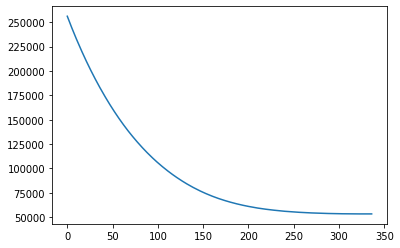

In [14]:
results['test-rmse-mean'].plot()

In [15]:
grid_params = [
    (max_depth, learning_rate, alpha)
    for max_depth in range(5,20,5)
    for learning_rate in [.01,.1,.5]
    for alpha in range(0,50,5)
]

min_rmse = float('inf')
best_params = None

for max_depth,learning_rate,alpha in grid_params:
    params = {
        'max_depth' : max_depth,
        'learning_rate' : learning_rate,
        'alpha' : alpha,
    }
    results = xgb.cv(
        params,
        data_matrix,
        num_boost_round=500,
        early_stopping_rounds=5,
        metrics='rmse',
    )
    current_rmse = results['test-rmse-mean'].min()
    if current_rmse < min_rmse:
        min_rmse = current_rmse
        best_params = (max_depth,learning_rate,alpha)
    print(f'Current best params: {best_params}')

Current best params: (5, 0.01, 0)
Current best params: (5, 0.01, 5)
Current best params: (5, 0.01, 5)
Current best params: (5, 0.01, 5)
Current best params: (5, 0.01, 20)
Current best params: (5, 0.01, 20)
Current best params: (5, 0.01, 20)
Current best params: (5, 0.01, 20)
Current best params: (5, 0.01, 40)
Current best params: (5, 0.01, 40)
Current best params: (5, 0.01, 40)
Current best params: (5, 0.01, 40)
Current best params: (5, 0.01, 40)
Current best params: (5, 0.01, 40)
Current best params: (5, 0.01, 40)
Current best params: (5, 0.01, 40)
Current best params: (5, 0.01, 40)
Current best params: (5, 0.01, 40)
Current best params: (5, 0.01, 40)
Current best params: (5, 0.01, 40)
Current best params: (5, 0.5, 0)
Current best params: (5, 0.5, 5)
Current best params: (5, 0.5, 10)
Current best params: (5, 0.5, 15)
Current best params: (5, 0.5, 20)
Current best params: (5, 0.5, 25)
Current best params: (5, 0.5, 30)
Current best params: (5, 0.5, 35)
Current best params: (5, 0.5, 40)


In [16]:
from sklearn.model_selection import train_test_split

In [17]:
xtrain, xtest, ytrain, ytest= train_test_split(X,y,test_size=.3,random_state=1234)

In [18]:
train_matrix = xgb.DMatrix(xtrain,ytrain)
test_matrix = xgb.DMatrix(xtest,ytest)

In [20]:
model = xgb.train(
    params,
    train_matrix,
    num_boost_round=500,
    early_stopping_rounds=5,
    evals=[(test_matrix,'test')],
)
model.save_model('kbc_house_model.xgb')

[0]	test-rmse:128478.05469
[1]	test-rmse:72552.41406
[2]	test-rmse:50759.97266
[3]	test-rmse:45224.84375
[4]	test-rmse:44384.85938
[5]	test-rmse:44402.20312
[6]	test-rmse:45123.16016
[7]	test-rmse:46184.93750
[8]	test-rmse:46765.60156
[9]	test-rmse:47195.58594


In [21]:
saved_model = xgb.Booster()
saved_model.load_model('kbc_house_model.xgb')

In [22]:
X.head(2)

,Beds,Baths,SquareFeet
0,2,1,836
1,3,1,1167


In [23]:
saved_model.predict(xgb.DMatrix(X.head(2)))

array([136308.56, 174246.06], dtype=float32)

In [24]:
y[:2]

0    138159.85
1    167541.46
Name: Price, dtype: float64

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

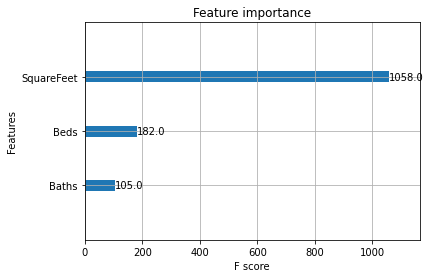

In [25]:
xgb.plot_importance(model)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

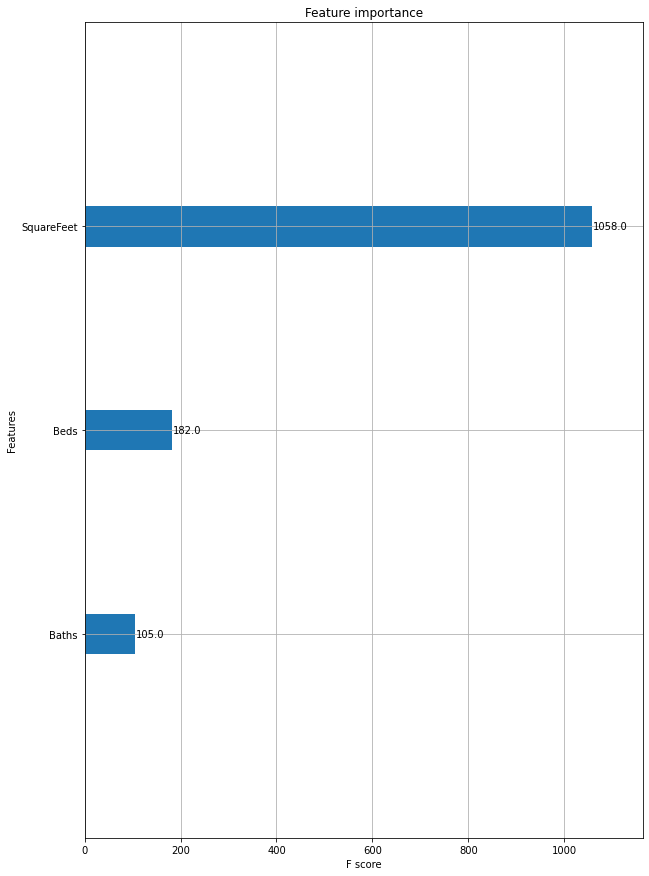

In [27]:
f,a = plt.subplots(figsize=(10,15))
xgb.plot_importance(model,ax=a)

In [31]:
model = LinearRegression()
model.fit(xtrain,ytrain)
model.score(xtest,ytest) * 100

78.35439807630098

In [32]:
pred = model.predict(X)

In [33]:
df['pred'] = pred

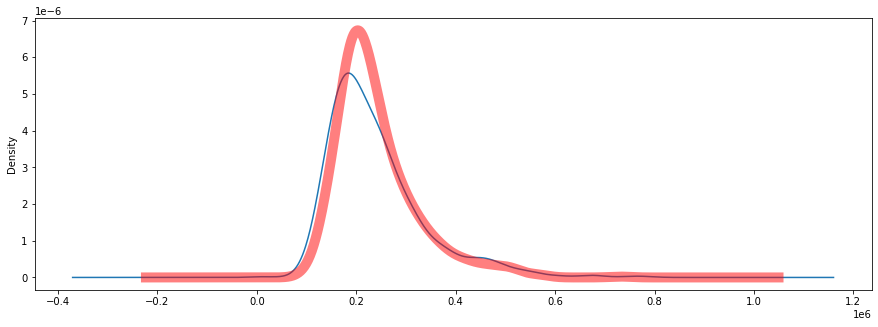

In [36]:
ax = df['Price'].plot(kind='kde',figsize=(15,5))
df['pred'].plot(kind='kde',ax=ax,color='red',alpha=.5,linewidth=10)
plt.show()